# 뉴스판별기


## 1. 로이터 뉴스 데이터에 대한 이해

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [3]:
fake = pd.read_csv('D:\workspace\Web\Fake.csv', encoding='latin1')
fake.head()


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Yearâ...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obamaâs Na...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
real = pd.read_csv('D:\workspace\Web\True.csv', encoding='latin1')
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
real_backup = real
fake_backup = fake


In [6]:
# Null 값을 가진 샘플이 있는지 확인
real.isnull().values.any()


False

In [7]:
fake.isnull().values.any()

False

In [8]:
# 데이터 중복이 있는지 확인
fake['title'].nunique()

17903

In [9]:
real['title'].nunique()


20826

In [10]:
real['tf'] = 1
fake['tf'] = 0

In [11]:
real.drop(['text', 'subject', 'date'], axis=1, inplace=True)
fake.drop(['text', 'subject', 'date'], axis=1, inplace=True)

In [12]:
data = pd.concat([real, fake])

In [13]:
data.groupby('tf').size()


tf
0    23481
1    21417
dtype: int64

In [14]:
X_data = data['title'].values
y_data = data['tf'].values
print('뉴스 총합:', len(X_data))
print('True/False:', len(y_data))

뉴스 총합: 44898
True/False: 44898


In [15]:
X_data

array(['As U.S. budget fight looms, Republicans flip their fiscal script',
       'U.S. military to accept transgender recruits on Monday: Pentagon',
       "Senior U.S. Republican senator: 'Let Mr. Mueller do his job'",
       ...,
       'Sunnistan: US and Allied â\x80\x98Safe Zoneâ\x80\x99 Plan to Take Territorial Booty in Northern Syria',
       'How to Blow $700 Million: Al Jazeera America Finally Calls it Quits',
       '10 U.S. Navy Sailors Held by Iranian Military â\x80\x93 Signs of a Neocon Political Stunt'],
      dtype=object)

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data) # 진짜 뉴스  행을 가진 X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(X_data) # 단어를 숫자값, 인덱스로 변환하여 저장

In [17]:
print(len(sequences))


44898


In [18]:
# 단어에 대한 인덱스
word_to_index = tokenizer.word_index
print(word_to_index) 

{'to': 1, 'trump': 2, 'in': 3, 'video': 4, 'of': 5, 'for': 6, 'on': 7, 'the': 8, 'u': 9, 's': 10, 'a': 11, 'and': 12, 'with': 13, 'says': 14, 'is': 15, 'after': 16, 'obama': 17, 'at': 18, 'as': 19, 'from': 20, 'over': 21, 'by': 22, 'house': 23, 'about': 24, 'watch': 25, 'his': 26, 'hillary': 27, 'new': 28, 'not': 29, 'will': 30, 'white': 31, 'clinton': 32, 'president': 33, 'trumpâ\x80\x99s': 34, 'be': 35, 'just': 36, 'he': 37, 'out': 38, 'it': 39, 'this': 40, 'bill': 41, 'russia': 42, 'who': 43, 'up': 44, 'that': 45, 'are': 46, 'republican': 47, 'state': 48, 'north': 49, 'against': 50, 'election': 51, 'court': 52, 'was': 53, 'her': 54, 'has': 55, 'him': 56, 'you': 57, 'senate': 58, 'breaking': 59, 'korea': 60, 'donald': 61, 'vote': 62, 'black': 63, 'news': 64, 'media': 65, 'how': 66, 'calls': 67, 'why': 68, 'anti': 69, 'tax': 70, 'no': 71, 'gop': 72, 'have': 73, 'police': 74, 'more': 75, 'republicans': 76, 'campaign': 77, 'â\x80\x93': 78, 'down': 79, 'muslim': 80, 'may': 81, 'what': 82

In [19]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100) 

등장 빈도가 1번 이하인 희귀 단어의 수: 11233
단어 집합(vocabulary)에서 희귀 단어의 비율: 35.32056724208408
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.9594401300595174


In [20]:
vocab_size = len(word_to_index)+1
vocab_size

31804

In [21]:
X_data = sequences
max_len = max(len(l) for l in X_data)
# print('진짜 뉴스 길이 : %d' % max_len)
#
# print('진짜 뉴스 평균 : %f' % (sum(map(len, X_data))/len(X_data)))
#
# plt.hist([len(s) for s in X_data], bins=50)
# plt.xlabel('length of Data')
# plt.ylabel('number of Data')
# plt.show()

In [22]:
# 전체 데이터셋의 길이를 max_len(189)에 맞춤
data = pad_sequences(X_data, maxlen=max_len)
# data.shape

In [23]:
# 테스트용 데이터 20% 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(data, y_data, test_size=.2, random_state=2020)

In [24]:
X_train.shape, y_train.shape

((35918, 44), (35918,))

In [25]:
# X_train.reshape(18784,44)

In [26]:
# 학습모델 형성 

In [27]:
from keras.layers import SimpleRNN, Embedding, Dense
from keras.models import Sequential

In [28]:
model = Sequential()
model.add(Embedding(vocab_size, 44)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(44))             # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 44)          1399376   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 44)                3916      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 45        
Total params: 1,403,337
Trainable params: 1,403,337
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [30]:
# 훈련용 데이터 중에서 20%는 검증 데이터로 사용
history = model.fit(X_train, y_train, epochs=10,
                    batch_size=60, validation_split=0.2, verbose=1)

C:\ProgramData\Anaconda3\envs\pyflask\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 28734 samples, validate on 7184 samples
Epoch 1/10
28734/28734 [==============================] - 13s 438us/step - loss: 0.1951 - accuracy: 0.9244 - val_loss: 0.0968 - val_accuracy: 0.9662
Epoch 2/10
28734/28734 [==============================] - 12s 421us/step - loss: 0.0635 - accuracy: 0.9776 - val_loss: 0.0750 - val_accuracy: 0.9748
Epoch 3/10
28734/28734 [==============================] - 12s 432us/step - loss: 0.0408 - accuracy: 0.9863 - val_loss: 0.0810 - val_accuracy: 0.9720
Epoch 4/10
28734/28734 [==============================] - 12s 426us/step - loss: 0.0264 - accuracy: 0.9910 - val_loss: 0.0849 - val_accuracy: 0.9727
Epoch 5/10
28734/28734 [==============================] - 12s 426us/step - loss: 0.0163 - accuracy: 0.9944 - val_loss: 0.1041 - val_accuracy: 0.9666
Epoch 6/10
28734/28734 [==============================] - 12s 424us/step - loss: 0.0079 - accuracy: 0.9974 - val_loss: 0.1276 - val_accuracy: 0.9628
Epoch 7/10
28734/28734 [==============================] -

In [31]:
# 테스트 정확도
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test, verbose=2)[1]))


 테스트 정확도: 0.9529


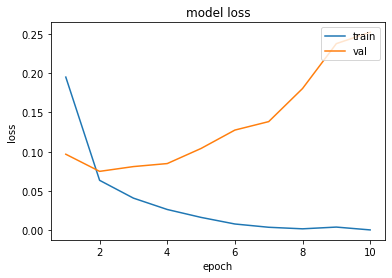

In [32]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [44]:
from keras.callbacks import ModelCheckpoint

news = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(10,60)
checkpoint = ModelCheckpoint(news,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

model.fit(X_train, y_train, 
      validation_data=(X_test, y_test),
      epochs=10, 
      batch_size=60, 
      callbacks=[checkpoint], # checkpoint 콜백
         )

Train on 35918 samples, validate on 8980 samples
Epoch 1/10
35918/35918 [==============================] - 15s 428us/step - loss: 5.5061e-10 - accuracy: 1.0000 - val_loss: 0.4576 - val_accuracy: 0.9478

Epoch 00001: val_loss improved from inf to 0.45761, saving model to checkpoint-epoch-10-batch-60-trial-001.h5
Epoch 2/10
35918/35918 [==============================] - 15s 424us/step - loss: 5.5298e-10 - accuracy: 1.0000 - val_loss: 0.4639 - val_accuracy: 0.9471

Epoch 00002: val_loss did not improve from 0.45761
Epoch 3/10
35918/35918 [==============================] - 15s 428us/step - loss: 5.5340e-10 - accuracy: 1.0000 - val_loss: 0.4586 - val_accuracy: 0.9473

Epoch 00003: val_loss did not improve from 0.45761
Epoch 4/10
35918/35918 [==============================] - 16s 447us/step - loss: 5.5312e-10 - accuracy: 1.0000 - val_loss: 0.4586 - val_accuracy: 0.9474

Epoch 00004: val_loss did not improve from 0.45761
Epoch 5/10
35918/35918 [==============================] - 16s 432us/step

In [45]:
# Best Model 선택
from keras.models import load_model
del model
model = load_model('checkpoint-epoch-10-batch-60-trial-001.h5')

C:\ProgramData\Anaconda3\envs\pyflask\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 44)          1399376   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 44)                3916      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 45        
Total params: 1,403,337
Trainable params: 1,403,337
Non-trainable params: 0
_________________________________________________________________


In [75]:
X_test[3]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0, 19107, 19108,  1315,   724,     1,
        2265,   381,    91,   346,   265,   271,     8,  5126])

In [74]:
y_test[3]

0

In [76]:
xtest= np.array([   0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0, 19107, 19108,  1315,   724,     1,
        2265,   381,    91,   346,   265,   271,     8,  5126]).reshape(1, 44)

In [77]:
model.evaluate(X_test, y_test)

8980/8980 [==============================] - 1s 75us/step


[0.4568893000181585, 0.9474387764930725]

In [78]:
model.predict_classes(xtest)[0][0]

0

In [65]:
xtest.shape

(44,)